In [1]:
from torch_geometric.nn import global_max_pool
import torch
from torch import Tensor
from torch.nn import Sequential, Linear, ReLU
import os
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm

In [2]:
class RoadIrregularityDataset(Dataset):
    def __init__(self, root_dir="../IrregData", transform=None):
        """
        Args:
            root_dir (str): Root directory containing multiple subfolders with feat/ and labels/.
            transform (callable, optional): Optional transform applied to each sample.
        """
        self.samples = []
        self.transform = transform

        for subfolder in sorted(os.listdir(root_dir)):
            folder_path = os.path.join(root_dir, subfolder)
            feat_dir = os.path.join(folder_path, 'feat')
            label_dir = os.path.join(folder_path, 'labels')

            if not os.path.isdir(feat_dir) or not os.path.isdir(label_dir):
                continue

            for file in sorted(os.listdir(feat_dir)):
                feat_path = os.path.join(feat_dir, file)
                label_path = os.path.join(label_dir, file)
                if os.path.exists(label_path):
                    self.samples.append((feat_path, label_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        feat_path, label_path = self.samples[idx]

        features = np.load(feat_path)     # shape (N, 4) or similar
        labels = np.load(label_path)      # shape (N,)

        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            features, labels = self.transform(features, labels)

        return features, labels


In [3]:
from torch_geometric.data import Data

class RoadIrregularityGeoDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        feat, label = self.base_dataset[idx]  # feat: [N, 4], label: [N]
        pos = feat[:, :3]   # [x, y, z]
        x = feat            # [x, y, z, intensity]
        y = label  # global residual label
        return Data(x=x, pos=pos, y=y)

In [4]:
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')

        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden
        # node dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(
            Linear(in_channels + 3, out_channels),
            ReLU(),
            Linear(out_channels, out_channels),
        )

    def forward(self,
        h: Tensor,
        pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self,
        h_j: Tensor,
        pos_j: Tensor,
        pos_i: Tensor,
    ) -> Tensor:
        # h_j: The features of neighbors as shape [num_edges, in_channels]
        # pos_j: The position of neighbors as shape [num_edges, 3]
        # pos_i: The central node position as shape [num_edges, 3]

        edge_feat = torch.cat([h_j, pos_j - pos_i], dim=-1)
        return self.mlp(edge_feat)

class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = PointNetLayer(4, 32)  # Use all 4 features
        self.conv2 = PointNetLayer(32, 32)
        self.regressor = Linear(32, 1)

    def forward(self, x, pos, edge_index, batch):
        h = self.conv1(x, pos, edge_index)
        h = torch.nn.functional.relu(h)
        h = self.conv2(h, pos, edge_index)
        h = torch.nn.functional.relu(h)
        return self.regressor(h)

model = PointNet()

In [5]:
from torch_geometric.nn import radius_graph

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for data in tqdm(loader):
        data = data.to(device)
        optimizer.zero_grad()
        edge_index = radius_graph(data.pos, r=0.2, batch=data.batch, max_num_neighbors=32)
        output = model(data.x, data.pos, edge_index, data.batch)
        loss = criterion(output.view(-1), data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            edge_index = radius_graph(data.pos, r=0.2, batch=data.batch, max_num_neighbors=32)
            output = model(data.x, data.pos, edge_index, data.batch)
            loss = criterion(output.view(-1), data.y.view(-1))
            total_loss += loss.item()

    return total_loss / len(loader)


In [6]:
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

# Load your dataset
base_dataset = RoadIrregularityDataset("../IrregData")
geo_dataset = RoadIrregularityGeoDataset(base_dataset)

# Train/val split
train_size = int(0.8 * len(geo_dataset))
val_size = len(geo_dataset) - train_size
train_ds, val_ds = random_split(geo_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

# Setup model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

# Training loop
val_losses = []
train_losses = []

for epoch in range(1, 31):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


100%|██████████| 124/124 [00:10<00:00, 12.02it/s]


Epoch 01 | Train Loss: 0.0120 | Val Loss: 0.0099


100%|██████████| 124/124 [00:10<00:00, 12.19it/s]


Epoch 02 | Train Loss: 0.0092 | Val Loss: 0.0093


100%|██████████| 124/124 [00:10<00:00, 12.05it/s]


Epoch 03 | Train Loss: 0.0082 | Val Loss: 0.0093


100%|██████████| 124/124 [00:10<00:00, 12.05it/s]


Epoch 04 | Train Loss: 0.0078 | Val Loss: 0.0092


100%|██████████| 124/124 [00:10<00:00, 12.05it/s]


Epoch 05 | Train Loss: 0.0077 | Val Loss: 0.0087


100%|██████████| 124/124 [00:10<00:00, 11.86it/s]


Epoch 06 | Train Loss: 0.0075 | Val Loss: 0.0086


100%|██████████| 124/124 [00:10<00:00, 11.84it/s]


Epoch 07 | Train Loss: 0.0069 | Val Loss: 0.0095


100%|██████████| 124/124 [00:10<00:00, 11.88it/s]


Epoch 08 | Train Loss: 0.0064 | Val Loss: 0.0074


100%|██████████| 124/124 [00:10<00:00, 11.75it/s]


Epoch 09 | Train Loss: 0.0063 | Val Loss: 0.0072


100%|██████████| 124/124 [00:10<00:00, 11.56it/s]


Epoch 10 | Train Loss: 0.0055 | Val Loss: 0.0060


100%|██████████| 124/124 [00:11<00:00, 10.82it/s]


Epoch 11 | Train Loss: 0.0043 | Val Loss: 0.0048


100%|██████████| 124/124 [00:11<00:00, 10.36it/s]


Epoch 12 | Train Loss: 0.0037 | Val Loss: 0.0045


100%|██████████| 124/124 [00:12<00:00, 10.15it/s]


Epoch 13 | Train Loss: 0.0031 | Val Loss: 0.0035


100%|██████████| 124/124 [00:12<00:00,  9.70it/s]


Epoch 14 | Train Loss: 0.0032 | Val Loss: 0.0034


100%|██████████| 124/124 [00:12<00:00,  9.55it/s]


Epoch 15 | Train Loss: 0.0030 | Val Loss: 0.0031


100%|██████████| 124/124 [00:12<00:00,  9.70it/s]


Epoch 16 | Train Loss: 0.0028 | Val Loss: 0.0035


100%|██████████| 124/124 [00:12<00:00,  9.60it/s]


Epoch 17 | Train Loss: 0.0027 | Val Loss: 0.0030


100%|██████████| 124/124 [00:12<00:00,  9.60it/s]


Epoch 18 | Train Loss: 0.0027 | Val Loss: 0.0031


100%|██████████| 124/124 [00:13<00:00,  9.53it/s]


Epoch 19 | Train Loss: 0.0026 | Val Loss: 0.0029


100%|██████████| 124/124 [00:12<00:00,  9.64it/s]


Epoch 20 | Train Loss: 0.0027 | Val Loss: 0.0030


100%|██████████| 124/124 [00:13<00:00,  9.52it/s]


Epoch 21 | Train Loss: 0.0026 | Val Loss: 0.0030


100%|██████████| 124/124 [00:13<00:00,  9.48it/s]


Epoch 22 | Train Loss: 0.0026 | Val Loss: 0.0030


100%|██████████| 124/124 [00:13<00:00,  9.25it/s]


Epoch 23 | Train Loss: 0.0027 | Val Loss: 0.0029


100%|██████████| 124/124 [00:13<00:00,  8.88it/s]


Epoch 24 | Train Loss: 0.0026 | Val Loss: 0.0029


100%|██████████| 124/124 [00:15<00:00,  7.93it/s]


Epoch 25 | Train Loss: 0.0026 | Val Loss: 0.0029


100%|██████████| 124/124 [00:15<00:00,  7.98it/s]


Epoch 26 | Train Loss: 0.0025 | Val Loss: 0.0034


100%|██████████| 124/124 [00:15<00:00,  8.00it/s]


Epoch 27 | Train Loss: 0.0027 | Val Loss: 0.0033


100%|██████████| 124/124 [00:15<00:00,  7.98it/s]


Epoch 28 | Train Loss: 0.0028 | Val Loss: 0.0030


100%|██████████| 124/124 [00:15<00:00,  7.97it/s]


Epoch 29 | Train Loss: 0.0025 | Val Loss: 0.0031


100%|██████████| 124/124 [00:15<00:00,  7.92it/s]


Epoch 30 | Train Loss: 0.0027 | Val Loss: 0.0029


In [7]:
torch.save(model.state_dict(), "irreg_model.pth")

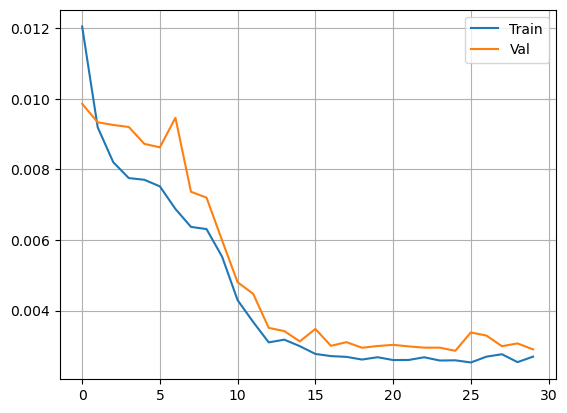

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.grid()
plt.legend()